In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pathlib import Path
from typing import Union

## Read metadata files:
- HAM10000 original metadata files
- DermaMNIST train-valid-test split information

In [3]:
ham10k_metadata_file: Union[str, Path] = Path("HAM10000_metadata.csv")
dermamnist_metadata_file: Union[str, Path] = Path("dermamnist_split_info.csv")

In [4]:
ham10k_metadata: pd.DataFrame = pd.read_csv(ham10k_metadata_file, header='infer')
dermamnist_metadata: pd.DataFrame = pd.read_csv(dermamnist_metadata_file, header='infer')
dermamnist_metadata: pd.DataFrame = dermamnist_metadata.drop('index', axis=1)

### Assert whether the dataframes have the same number of rows and print their `head()`.

In [5]:
assert ham10k_metadata.shape[0] == dermamnist_metadata.shape[0]

In [6]:
ham10k_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [7]:
dermamnist_metadata.head()

,split,image_id
0,train,ISIC_0027615
1,train,ISIC_0029876
2,train,ISIC_0031193
3,train,ISIC_0030743
4,train,ISIC_0026475


## Combine the 2 dataframes into one based on the shared `image_id`.

In [8]:
combined_metadata: pd.DataFrame = pd.merge(ham10k_metadata, dermamnist_metadata, on='image_id')

# Assert that the combine operation did not drop any rows.
assert combined_metadata.shape[0] == dermamnist_metadata.shape[0]

In [9]:
combined_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,test
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,train


### Export the combined dataframe as a CSV file.

In [10]:
combined_metadata.to_csv(Path("CSV_files/combined_metadata_original.csv"), index=False)

## Analyzing the combined dataframe:
- Count the number of unique `lesion_id` values.
- Count the frequency of `lesion_id` repeated against the lesion images (rows) in the dataframe. This means counting how many `lesion_id` values are repeated 1 time, 2 times, 3 times, etc.
- Plot the above frequency distribution. Use a log-scale.

In [11]:
# Count the number of unique `lesion_id` values.
combined_metadata['lesion_id'].nunique()

7470

In [12]:
# Count the frequency of `lesion_id` values.
combined_metadata['lesion_id'].value_counts().value_counts()

1    5514
2    1423
3     490
4      34
5       5
6       4
Name: lesion_id, dtype: int64

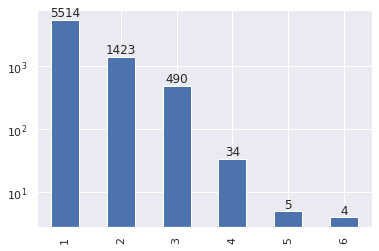

In [13]:
# Plot using matplotlib.

ax = combined_metadata['lesion_id'].value_counts().value_counts().sort_index().plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container)

plt.yscale("log")

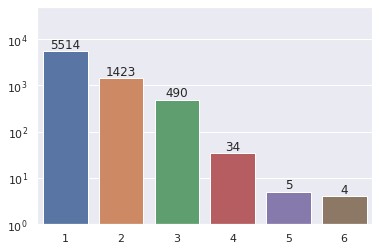

In [14]:
# Plot using seaborn.

combined_stats_toplot = combined_metadata['lesion_id'].value_counts().value_counts().sort_index()

ax = sns.barplot(x=combined_stats_toplot.index, y=combined_stats_toplot.values)

ax.bar_label(ax.containers[0])

ax.set(ylim=(1, 5e4))
ax.set_yscale("log")

## Correcting the partitions

We adopt a standard naming scheme to denote sets: `xyz`, where `x`, `y`, and `z` denote training, validation, and testing partitions, and can each be either `0` or `1` denoting whether elements from those partitions are present.

Accordingly:

- `110` -> train_valid
- `101` -> train_test
- `010` -> valid
- `011` -> valid_test
- `111` -> train_valid_test

In [15]:
'''
Naming scheme: train_valid_test
110 -> train_valid
101 -> train_test
010 -> valid
011 -> valid_test
111 -> train_valid_test
'''

selected_rows = {}

# We first create the partitions originally present in DermaMNIST, and print the number of
# images in each partition.

for split in ['train', 'val', 'test']:
    selected_rows[split] = combined_metadata[combined_metadata['split']==split]
    print(f'{split} -> {selected_rows[split].shape[0]} images')

# Next, we find `lesion_id` intersections between the partitions. There are 4 such intersections:
# - train-test
# - train-val
# - val-test
# - train-val-test
    
intersect_101 = pd.merge(selected_rows['train'], selected_rows['test'], how='inner', on='lesion_id')
intersect_110 = pd.merge(selected_rows['train'], selected_rows['val'], how='inner', on='lesion_id')
intersect_011 = pd.merge(selected_rows['val'], selected_rows['test'], how='inner', on='lesion_id')
intersect_111 = pd.merge(intersect_110, selected_rows['test'], how='inner', on='lesion_id')

print(f'train-test lesion_id overlap: {intersect_101.shape[0]} images')
print(f'train-val lesion_id overlap: {intersect_110.shape[0]} images')
print(f'val-test lesion_id overlap: {intersect_011.shape[0]} images')
print(f'train-val-test lesion_id overlap: {intersect_111.shape[0]} images')

train -> 7007 images
val -> 1003 images
test -> 2005 images
train-test lesion_id overlap: 886 images
train-val lesion_id overlap: 440 images
val-test lesion_id overlap: 128 images
train-val-test lesion_id overlap: 51 images


In [16]:
lesionID_101 = intersect_101["lesion_id"].unique()
lesionID_110 = intersect_110["lesion_id"].unique()
lesionID_011 = intersect_011["lesion_id"].unique()
lesionID_111 = intersect_111["lesion_id"].unique()

print(f'train-test lesion_id overlap: {lesionID_101.shape[0]} lesions/lesion IDs')
print(f'train-val lesion_id overlap: {lesionID_110.shape[0]} lesions/lesion IDs')
print(f'val-test lesion_id overlap: {lesionID_011.shape[0]} lesions/lesion IDs')
print(f'train-val-test lesion_id overlap: {lesionID_111.shape[0]} lesions/lesion IDs')

train-test lesion_id overlap: 641 lesions/lesion IDs
train-val lesion_id overlap: 332 lesions/lesion IDs
val-test lesion_id overlap: 113 lesions/lesion IDs
train-val-test lesion_id overlap: 40 lesions/lesion IDs


## Duplicate removal strategy

There should be three partitions of the dataset: `train`, `val`, and `test`.

Taking into account the intersections, there are 4 intersections (as before, based on lesion ID): `train-test`, `train-val`, `val-test`, and `train-val-test`. We need to ensure that these intersections are empty.

Approach: if a lesion ID appears in `train` partition, we remove all of its occurrences from all the other partitions and all the intersections.

### corrected

In [17]:
# Find lesion ID duplicates between `train` and {`val`, `test`}.

val_duplicates = selected_rows["val"].loc[selected_rows["val"]["lesion_id"].isin(lesionID_110)]
test_duplicates = selected_rows["test"].loc[selected_rows["test"]["lesion_id"].isin(lesionID_101)]

# Find lesion ID duplicates between `val` and `val-test` and between `test` and `val-test`.

val_shared_duplicates = selected_rows["val"].loc[selected_rows["val"]["lesion_id"].isin(lesionID_011)]
test_shared_duplicates = selected_rows["test"].loc[selected_rows["test"]["lesion_id"].isin(lesionID_011)]

# print(val_duplicates.shape, test_duplicates.shape)
# print(val_shared_duplicates.shape, test_shared_duplicates.shape)



# Store the corrected partitions in `corrected`, since we are moving all violating lesion IDs
# to the `train` partition.

corrected = {}

# In the `train` partition, add elements from the other 2 partitions and the intersections, 
# and remove duplicates since there are bound to be some.

corrected["train"] = pd.concat(
    [
        selected_rows["train"],
        val_duplicates,
        test_duplicates,
        val_shared_duplicates,
        test_shared_duplicates,
    ],
    ignore_index=True
)
corrected["train"] = corrected["train"].drop_duplicates()

# Re-label the `split` attribute of all the entries in `train` to `train`.

corrected["train"]["split"] = "train"



# In the `val` and the `test` partitions, remove the duplicates obtained using the union 
# of the respective partitions and from the intersections.

corrected["val"] = (
    selected_rows["val"]
    .drop(val_duplicates.index.union(val_shared_duplicates.index))
)

corrected["test"] = (
    selected_rows["test"]
    .drop(test_duplicates.index.union(test_shared_duplicates.index))
)

for split in ['train', 'val', 'test']:
    print(f'[corrected] new {split} -> {corrected[split].shape[0]} images')
    

    
# Check that there are no more overlaps among the partitions.
    
assert pd.merge(corrected['train'], corrected['val'], how='inner', on='lesion_id').shape[0] == 0
assert pd.merge(corrected['train'], corrected['test'], how='inner', on='lesion_id').shape[0] == 0
assert pd.merge(corrected['test'], corrected['val'], how='inner', on='lesion_id').shape[0] == 0

dfs_to_merge = [corrected['train'], corrected['val'], corrected['test']]



# Concatenate all the partitions into a single DataFrame, check that it has neither 
# any missing rows nor any duplicate rows, and then export it to file.

corrected_df = pd.concat(dfs_to_merge, axis=0, ignore_index=True)

assert corrected_df.duplicated(keep=False).shape[0] == corrected_df.shape[0]
assert corrected_df.shape[0] == combined_metadata.shape[0]
corrected_df.to_csv(Path("CSV_files/combined_metadata_corrected.csv"), index=False)

[corrected] new train -> 8208 images
[corrected] new val -> 575 images
[corrected] new test -> 1232 images
